## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [1]:
import pickle
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dfrequency = pd.DataFrame(token_freq, columns = ['Token', 'Frequency'])
dfrequency.head()

,Token,Frequency
0,new,1365
1,date,1202
2,get,1052
3,please,1022
4,enron,927


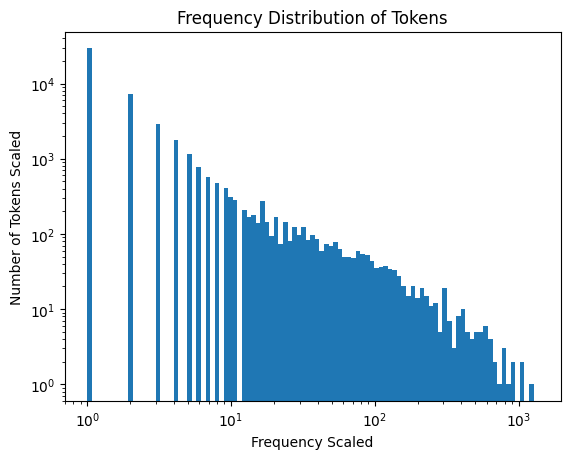

In [4]:
frequency = dfrequency['Frequency'].values
bins = np.logspace(np.log10(frequency.min()), np.log10(frequency.max()), 100)
plt.hist(frequency, bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency Scaled')
plt.ylabel('Number of Tokens Scaled')
plt.title('Frequency Distribution of Tokens')
plt.show()

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [5]:
phishing = pd.read_parquet('Phishing_clean.parquet')
phishing.head()

,Email Type,new,date,get,please,enron,like,2002,would,one,...,ï¿½ï¿½,safety,yap,ypil,maintain,procedures,tip,elizabeth,leadership,italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
from sklearn.model_selection import train_test_split

X = phishing.drop(columns = ['Email Type'])
y = phishing['Email Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X_train, y_train)
y_trainpred = model.predict(X_train)
y_testpred = model.predict(X_test)

r2_train =  r2_score(y_train, y_trainpred)
r2_test = r2_score(y_test, y_testpred)

print(f'R^2 on training set: {r2_train}')
print(f'R^2 on test set: {r2_test}')

R^2 on training set: 0.7670143724934355
R^2 on test set: 0.6658718438847919


In [9]:
words = pd.DataFrame({'Token': X.columns, 'Coefficient': model.coef_})
words['abs_coefficient'] = abs(words['Coefficient'])
words = words.sort_values(by = 'abs_coefficient', ascending = False)

words.head(10)

,Token,Coefficient,abs_coefficient
835,intervention,-1.259257,1.259257
740,localized,0.824350,0.824350
2362,thermal,0.747006,0.747006
851,crawler,0.696167,0.696167
1504,background-image:,-0.622909,0.622909
1406,"helvetica,",0.598560,0.598560
906,aging,0.594956,0.594956
1839,form.,0.576886,0.576886
2242,gray;,-0.574480,0.574480
1552,a:active,0.574480,0.574480


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

In [10]:
email = pd.read_parquet('Phishing_clean.parquet')
X = email.drop(columns = ['Email Type'])
y = email['Email Type']

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean = False)
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns = ['PC1', 'PC2'])
pca_df['Email Type'] = y.values
pca_df.head()

,PC1,PC2,Email Type
0,-0.108245,-0.172806,0
1,-0.089033,-0.276833,0
2,-0.213159,-0.313051,0
3,-0.143496,-0.209145,1
4,-0.059001,-0.316032,1


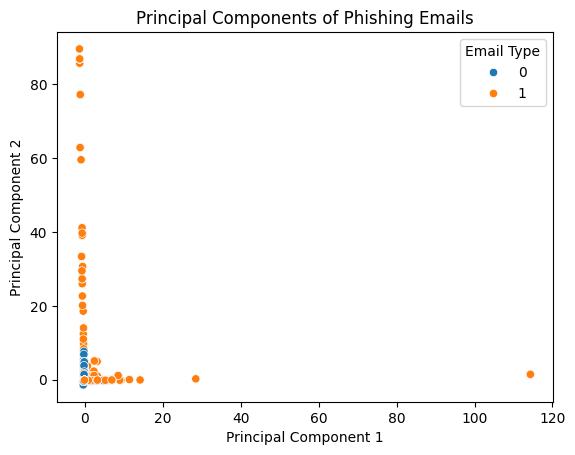

In [14]:
sns.scatterplot(data = pca_df, x='PC1' , y='PC2', hue='Email Type')
plt.title('Principal Components of Phishing Emails')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler(with_mean = False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components = 2610)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [16]:
linear = LinearRegression()
linear.fit(X_train_pca, y_train)

y_train_pred = linear.predict(X_train_pca)
y_test_pred = linear.predict(X_test_pca)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'R^2 on PCA training set: {r2_train}')
print(f'R^2 on PCA test set: {r2_test}')

R^2 on PCA training set: 0.7660928423789811
R^2 on PCA test set: 0.6684172405887812


The performance is very comparable to the previous linear regression as the R^2 values are close to that of the original. The R^2 on the training set is better for the original calculations, but the R^2 value was better for the PCA test set.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.